In [225]:
#bibliotecas utilizadas
import scipy as spy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import control as ctrl
#import slycot
from scipy import signal

Parâmetros

In [226]:
#constantes
Lc= 0.19 #m
kb= 40000.0 #N/m
kt= 50502.0 #N/m
km= 30250.0 #N/m
kcinto= 52500.0 #N/m
kpe= 105000.0 #N/m
bb= 220.0 #N.s/m 
bt= 443.1 #N.s/m
bm= 2408.04 #N.s/m
bcinto= 250.0 #N.s/m
bpe= 325.0 #N.s/m



mb= 35.0 #kg
mt= 42.609 #kg
mm= 21.238 #kg
mc= 6.153 #kg
jc= 0.02 #kg/m^2
Bc= 2.4692 #N.m.s/rad
Kc= 21.678 #N.m/rad
g = 9.8 #m/s^2
# Parâmetros de simulação
tf = 20.0
t = np.linspace(0, tf, 100000)



Análise de estabilidade aceleração

Polos do sistema: [-133.40879759 +0.j           -8.35890059+59.02722081j
   -8.35890059-59.02722081j  -14.69178861+31.79559828j
  -14.69178861-31.79559828j  -26.5923856  +0.j
   -5.0990549  +4.0266784j    -5.0990549  -4.0266784j ]


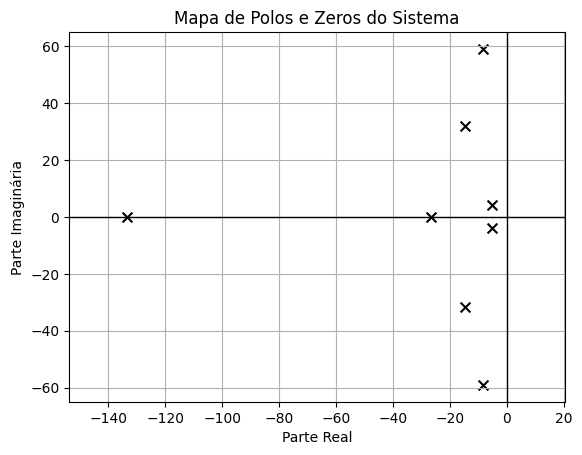

Função de Transferência para saída 1:

 1.99e-13 s^7 + 1.455e-11 s^6 + 5.644e+06 s^5 + 2.277e+08 s^4 + 1.281e+10 s^3 - 4.699e+10 s^2 - 1.222e+12 s - 6.951e+12
------------------------------------------------------------------------------------------------------------------------
s^8 + 216.3 s^7 + 1.834e+04 s^6 + 1.306e+06 s^5 + 5.528e+07 s^4 + 1.628e+09 s^3 + 2.892e+10 s^2 + 2.059e+11 s + 6.53e+11



Função de Transferência para saída 2:

     5.644e+06 s^7 + 2.277e+08 s^6 + 1.281e+10 s^5 - 4.699e+10 s^4 - 1.222e+12 s^3 - 6.951e+12 s^2 + 1892 s + 3929
------------------------------------------------------------------------------------------------------------------------
s^8 + 216.3 s^7 + 1.834e+04 s^6 + 1.306e+06 s^5 + 5.528e+07 s^4 + 1.628e+09 s^3 + 2.892e+10 s^2 + 2.059e+11 s + 6.53e+11





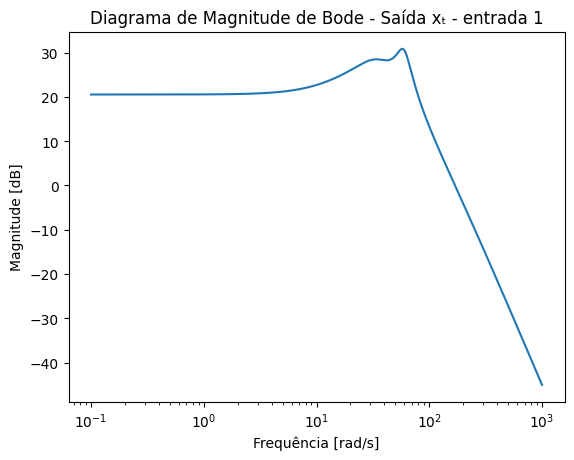

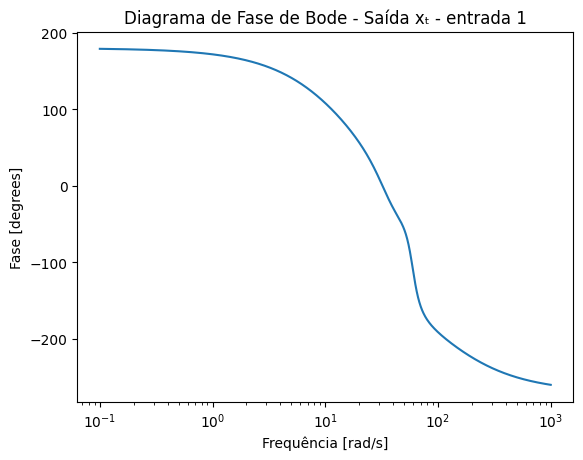

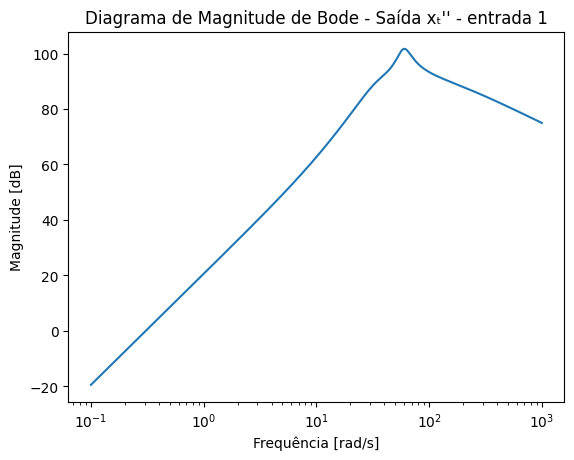

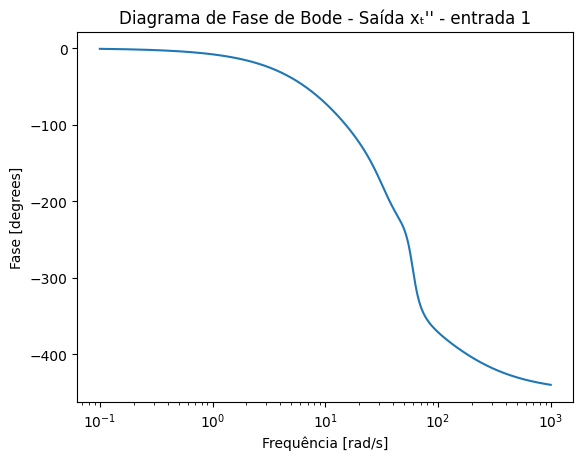

In [227]:
# Defina as matrizes do espaço de estados
A = np.array([[0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 1],
              [-(kb+kt)/mb, -kt/mb, 0, 0, -(bb+bt)/mb,   -bt/mb, 0, 0],
              [-kt/(mt+mc), -(kt+km)/(mt+mc), km/(mt+mc), 0, bt/(mt+mc), -(bt+bm)/(mt+mc), bm/(mt+mc), 0],
              [0, km/mm, -(km+kpe)/mm, 0, 0, bm/mm, -(bm+bpe)/mm, 0],
              [0, 0, 0, (mc*Lc*g-Kc)/(jc+mc*Lc**2), 0, 0, 0, -Bc/(jc+mc*Lc**2)]])

B = np.array([[0], [0], [0], [0], [kt], [0], [kpe], [0]])

C = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
              [-kt/(mt+mc), -(kt+km)/(mt+mc), km/(mt+mc), 0, bt/(mt+mc), -(bt+bm)/(mt+mc), bm/(mt+mc), 0]])

D = np.array([[0], [0]])

# Obtenha os polos do sistema
polos = np.linalg.eigvals(A)

# Imprima os polos
print("Polos do sistema:", polos)

# Crie um mapa de polos
plt.figure()
ctrl.pzmap(ctrl.ss(A, np.zeros_like(A), np.eye(len(A)), np.zeros((len(A), len(A[0])))))
plt.title('Mapa de Polos e Zeros do Sistema')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.grid(True)
plt.show()

# Crie um sistema de espaço de estados
sys_ss = ctrl.StateSpace(A, B, C, D)

# Obtenha o número de saídas e entradas
num_outputs = sys_ss.C.shape[0]
num_inputs = sys_ss.B.shape[1]

# Inicialize uma lista para armazenar as funções de transferência
sys_tf_list = []

# Itere sobre as saídas
for i in range(num_outputs):
    # Itere sobre as entradas
    for j in range(num_inputs):
        sys_tf_list.append(ctrl.ss2tf(sys_ss[i, j]))
        
for idx, sys_tf in enumerate(sys_tf_list):
    print(f"Função de Transferência para saída {idx+1}:")
    print(sys_tf)
    print("\n")

numeradores = [
[1.99e-13, 1.455e-11, 5.644e6, 2.277e8, 1.281e10, -4.699e10, -1.222e12, -6.951e12],
[5.644e6, 2.277e8, 1.281e10, -4.699e10, -1.222e12, -6.951e12, 1892, 3929]
]
denominador = [1, 216.3, 1.834e4, 1.306e6, 5.528e7, 1.628e9, 2.892e10, 2.059e11, 6.53e11]

# Nomes para as saídas
nomes_saidas = nomes_saidas = ["Saída xₜ - entrada 1", "Saída xₜ'' - entrada 1"]

# Faixa de frequência desejada (de 10^-1 a 10^3 rad/s)
freq_min = 1e-1
freq_max = 1e3

# Loop sobre as diferentes listas de numeradores
for i, num in enumerate(numeradores):
    sys = signal.TransferFunction(num, denominador)

    # Calcular a resposta em frequência na faixa desejada
    w, mag, phase = signal.bode(sys, np.logspace(np.log10(freq_min), np.log10(freq_max), num=1000))

    # Plotar o diagrama de Bode com títulos específicos
    plt.figure()
    plt.semilogx(w, mag)    # Bode magnitude plot
    plt.title(f'Diagrama de Magnitude de Bode - {nomes_saidas[i]}')
    plt.xlabel('Frequência [rad/s]')
    plt.ylabel('Magnitude [dB]')

    plt.figure()
    plt.semilogx(w, phase)  # Bode phase plot
    plt.title(f'Diagrama de Fase de Bode - {nomes_saidas[i]}')
    plt.xlabel('Frequência [rad/s]')
    plt.ylabel('Fase [degrees]')

plt.show()


Análise estabilidade frenagem

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-2.64285714e+03 -1.50000000e+03  0.00000000e+00  0.00000000e+00
  -1.34285714e+01 -7.14285714e+00  0.00000000e+00  0.00000000e+00]
 [-1.07665805e+03 -1.69701817e+03  6.20360116e+02  0.00000000e+00
   5.12694311e+00 -5.45104795e+01  4.93835364e+01  0.00000000e+00]
 [ 0.00000000e+00  1.42433374e+03 -6.36830210e+03  0.00000000e+00
   0.00000000e+00  1.13383558e+02 -1.28686317e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.22144998e+01
   

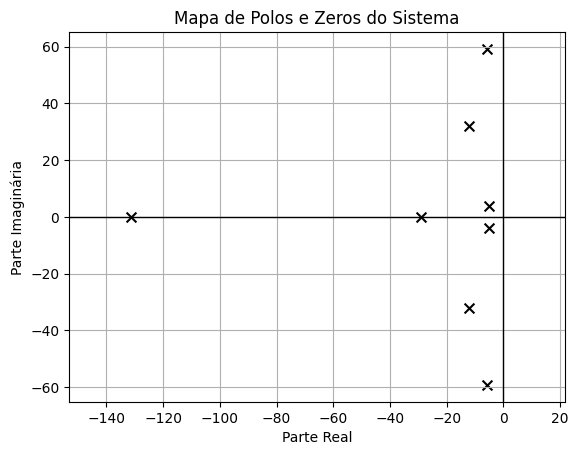

Função de Transferência para saída 1:

 7.105e-13 s^7 + 1.019e-10 s^6 - 5.444e+06 s^5 - 1.692e+08 s^4 - 1.062e+10 s^3 + 7.518e+10 s^2 + 1.386e+12 s + 7.35e+12
------------------------------------------------------------------------------------------------------------------------
s^8 + 206.8 s^7 + 1.667e+04 s^6 + 1.198e+06 s^5 + 5.054e+07 s^4 + 1.493e+09 s^3 + 2.829e+10 s^2 + 2.068e+11 s + 6.73e+11



Função de Transferência para saída 2:

-5.644e+06 s^7 - 1.884e+08 s^6 - 1.27e+10 s^5 + 1.654e+10 s^4 - 2.294e+12 s^3 - 3.638e+13 s^2 - 2.312e+14 s - 3.967e+14
------------------------------------------------------------------------------------------------------------------------
s^8 + 206.8 s^7 + 1.667e+04 s^6 + 1.198e+06 s^5 + 5.054e+07 s^4 + 1.493e+09 s^3 + 2.829e+10 s^2 + 2.068e+11 s + 6.73e+11





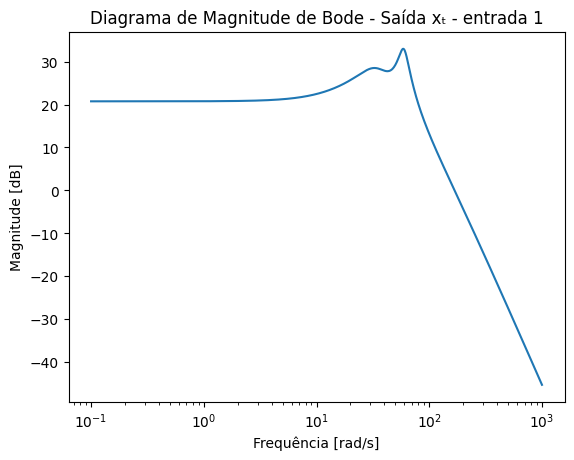

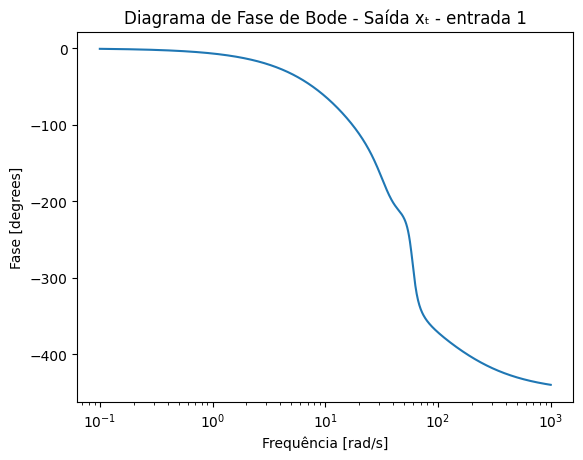

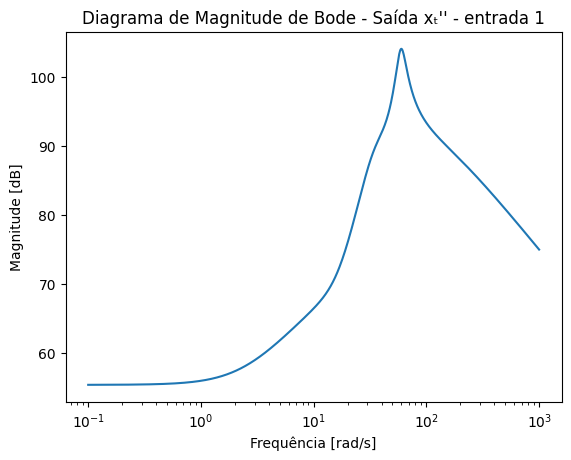

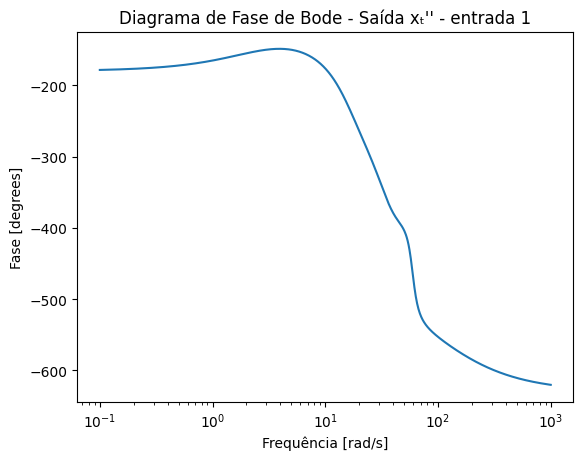

In [228]:
# Defina as matrizes do espaço de estados
A = np.array([[0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 1],
              [-(kb+kcinto)/mb, -kcinto/mb, 0, 0, -(bb+bcinto)/mb, -bcinto/mb, 0, 0],
              [-kcinto/(mt+mc), -(kcinto+km)/(mt+mc), km/(mt+mc), 0, bcinto/(mt+mc), -(bcinto+bm)/(mt+mc), bm/(mt+mc), 0],
              [0, km/mm, -(km+kpe)/mm, 0, 0, bm/mm, -(bm+bpe)/mm, 0],
              [0, 0, 0, (mc*Lc*g-Kc)/(jc+mc*Lc**2), 0, 0, 0, -Bc/(jc+mc*Lc**2)]])

print(A)

B = np.array([[0], [0], [0], [0], [-kt], [0], [-kpe], [0]])

C = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
              [-kt/(mt+mc), -(kt+km)/(mt+mc), km/(mt+mc), 0, bt/(mt+mc), -(bt+bm)/(mt+mc), bm/(mt+mc), 0]])

D = np.array([[0], [0]])

# Obtenha os polos do sistema
polos = np.linalg.eigvals(A)

# Imprima os polos
print("Polos do sistema:", polos)

# Crie um mapa de polos
plt.figure()
ctrl.pzmap(ctrl.ss(A, np.zeros_like(A), np.eye(len(A)), np.zeros((len(A), len(A[0])))))
plt.title('Mapa de Polos e Zeros do Sistema')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.grid(True)
plt.show()

# Crie um sistema de espaço de estados
sys_ss = ctrl.StateSpace(A, B, C, D)

# Obtenha o número de saídas e entradas
num_outputs = sys_ss.C.shape[0]
num_inputs = sys_ss.B.shape[1]

# Inicialize uma lista para armazenar as funções de transferência
sys_tf_list = []

# Itere sobre as saídas
for i in range(num_outputs):
    # Itere sobre as entradas
    for j in range(num_inputs):
        sys_tf_list.append(ctrl.ss2tf(sys_ss[i, j]))
        
for idx, sys_tf in enumerate(sys_tf_list):
    print(f"Função de Transferência para saída {idx+1}:")
    print(sys_tf)
    print("\n")

numeradores = [[7.105e-13, 1.019e-10, -5.444e6, -1.692e8, -1.062e10, 7.518e10, 1.386e12, 7.35e12],
               [-5.644e6, -1.884e8, -1.27e10, 1.654e10, -2.294e12, -3.638e13, -2.312e14, -3.967e14]
]
denominador = [1, 206.8, 1.667e4, 1.198e6, 5.054e7, 1.493e9, 2.829e10, 2.068e11, 6.73e11]

# Nomes para as saídas
nomes_saidas = ["Saída xₜ - entrada 1", "Saída xₜ'' - entrada 1"]

# Faixa de frequência desejada (de 10^-1 a 10^3 rad/s)
freq_min = 1e-1
freq_max = 1e3

# Loop sobre as diferentes listas de numeradores
for i, num in enumerate(numeradores):
    sys = signal.TransferFunction(num, denominador)

    # Calcular a resposta em frequência na faixa desejada
    w, mag, phase = signal.bode(sys, np.logspace(np.log10(freq_min), np.log10(freq_max), num=1000))

    # Plotar o diagrama de Bode com títulos específicos
    plt.figure()
    plt.semilogx(w, mag)    # Bode magnitude plot
    plt.title(f'Diagrama de Magnitude de Bode - {nomes_saidas[i]}')
    plt.xlabel('Frequência [rad/s]')
    plt.ylabel('Magnitude [dB]')

    plt.figure()
    plt.semilogx(w, phase)  # Bode phase plot
    plt.title(f'Diagrama de Fase de Bode - {nomes_saidas[i]}')
    plt.xlabel('Frequência [rad/s]')
    plt.ylabel('Fase [degrees]')

plt.show()



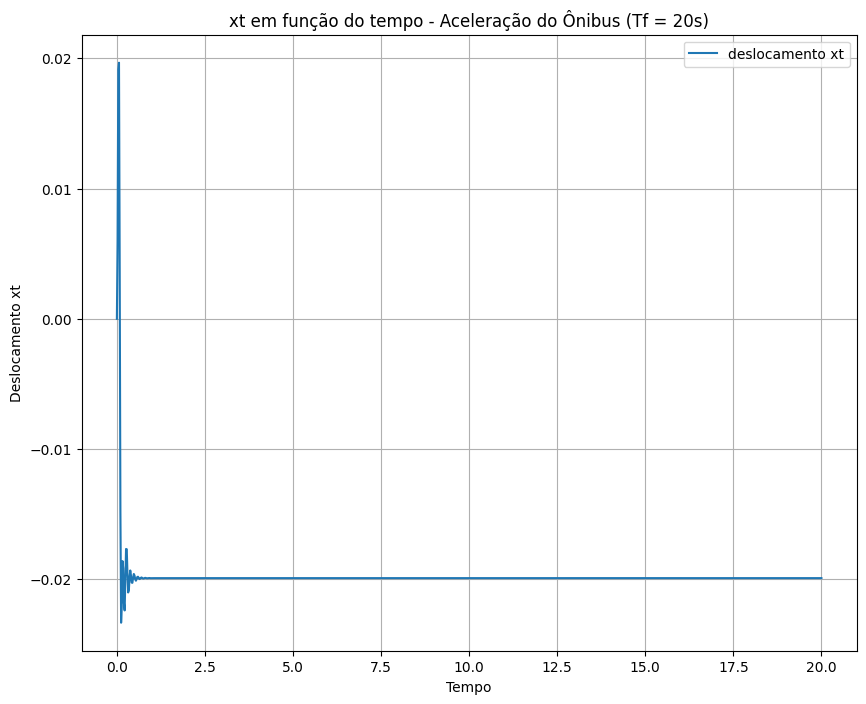

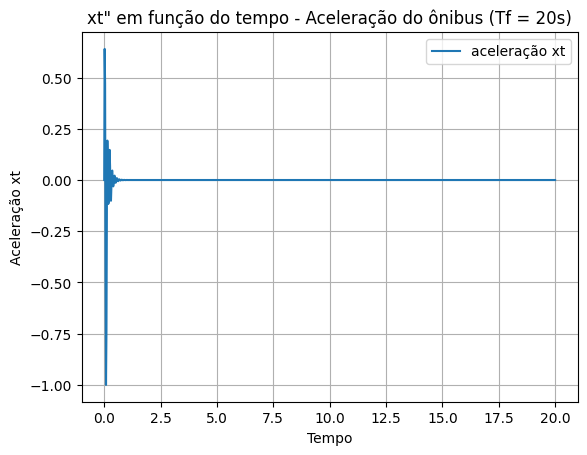

In [229]:
#aceleração com 20s




u = 0.00187 #m

def equations(t, y, mb, mt, mm, mc, jc, Bc, Kc, g, Lc, kb, kt, km, kcinto, kpe, bb, bt, bm, bcinto, bpe, u):
    xb, xt, xm, theta, xb_p, xt_p, xm_p, theta_p = y

    
    eq1 = xb_p
    eq2 = xt_p
    eq3 = xm_p
    eq4 = theta_p

    eq5 = -((kb+kt)/mb)*xb-(kt/mb)*xt-((bb+bt)/mb)*xb_p-(bt/mb)*xt_p + kt*u

    eq6 = -(kt/(mt+mc))*xb-((kt+km)/(mt+mc))*xt+(km/(mt+mc))*xm+(bt/(mt+mc))*xb_p-((bt+bm)/(mt+mc))*xt_p+(bm/(mt+mc))*xm_p  

    eq7 = (km/mm)*xt-((km+kpe)/mm)*xm+(bm/mm)*xt_p-((bm+bpe)/mm)*xm_p + kpe*u

    eq8 = ((mc*Lc*g-Kc)/(jc+mc*Lc**2))*theta-((Bc)/jc+mc*Lc**2)*theta_p

    return [eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8]



# Condições iniciais
initial_conditions = [0, 0, 0, 0, 0, 0, 0, 0]

# Tempo de integração
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solução do sistema de equações diferenciais
sol = solve_ivp(
    fun=lambda t, y: equations(t, y, mb, mt, mm, mc, jc, Bc, Kc, g, Lc, kb, kt, km, kcinto, kpe, bb, bt, bm, bcinto, bpe, u),
    t_span=t_span,
    y0=initial_conditions,
    t_eval=t_eval,
    method='DOP853'
)

# Plotando os resultados
plt.figure(figsize=(10, 8))

plt.plot(sol.t, sol.y[1], label='deslocamento xt')
plt.title('xt em função do tempo - Aceleração do Ônibus (Tf = 20s)')
plt.xlabel('Tempo')
plt.ylabel('Deslocamento xt')
plt.legend()
plt.grid(True)
plt.show()
plt.plot(sol.t, sol.y[5], label='aceleração xt')
plt.title('xt" em função do tempo - Aceleração do ônibus (Tf = 20s)')
plt.xlabel('Tempo')
plt.ylabel('Aceleração xt')
plt.legend()
plt.grid(True)
plt.show()

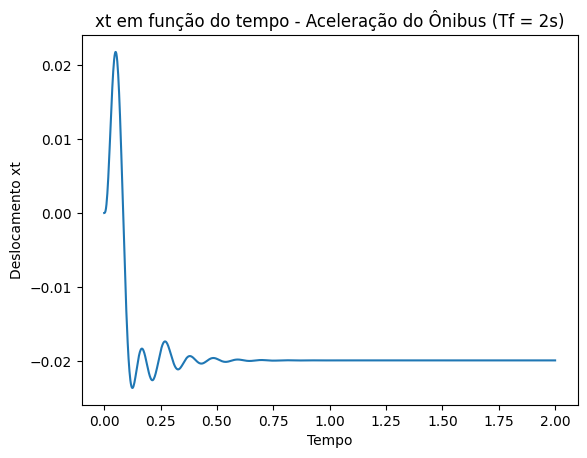

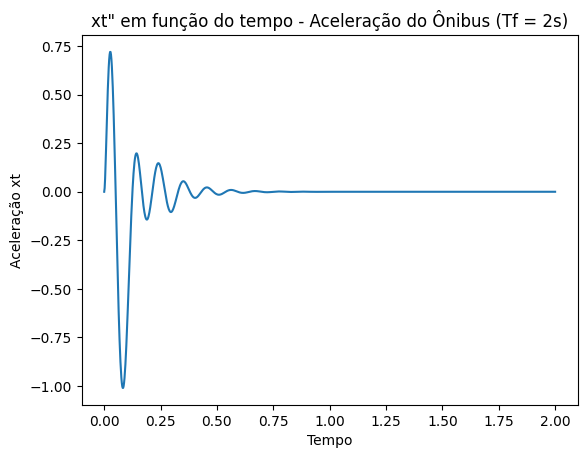

In [230]:
#aceleração com 2s
# Condições iniciais
xb0 = 0  # m
xt0 = 0  # m (ajustado para um valor diferente de zero)
xp0 = 0  # m (ajustado para um valor diferente de zero)
teta0 = 0  # rad
xbp0 = 0  # m
xtp0 = 0  # m
xmp0 = 0  # m
tetap0 = 0  # rad

u = 0.00187 #m

# Condições iniciais do sistema
x0 = [xb0, xt0, xp0, teta0, xbp0, xtp0, xmp0, tetap0]

def sistema_naoLinear(t, x):
    xb, xt, xm, teta, xbp, xtp, xmp, tetap = x

    # Equações do sistema

    eq1 = xbp
    eq2 = xtp
    eq3 = xmp
    eq4 = tetap
    
    eq5 = -((kb + kt) / mb) * xb - (kt / mb) * xt - ((bb + bt) / mb) * xbp - (bt / mb) * xtp + kt*u 

    eq6 = -(kt / (mt + mc)) * xb - ((kt + km) / (mt + mc)) * xt + (km / (mt + mc)) * xm + (bt / (mt + mc)) * xbp - (
                (bt + bm) / (mt + mc)) * xtp + (bm / (mt + mc)) * xmp
     
    eq7 = (km / mm) * xt - ((km + kpe) / mm) * xm + (bm / mm) * xtp - ((bm + bpe) / mm) * xmp + kpe*u
    
    eq8 = ((mc * Lc * g - Kc) / (jc + mc * Lc ** 2)) * teta - ((Bc) / (jc + mc * Lc ** 2)) * tetap 

    

    return [eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8]

tf = 2.0
t = np.linspace(0, tf, 1000)

# Resolvendo as equações
s_n = solve_ivp(sistema_naoLinear, [0, tf], x0, method='DOP853', dense_output=True)
x_n = s_n.sol(t)

xt = x_n[1]
xt_pp = x_n[5]

# Plote o gráfico para a equação 2 (xt)
plt.title('xt em função do tempo - Aceleração do Ônibus (Tf = 2s)')
plt.plot(t, xt)
plt.xlabel('Tempo')
plt.ylabel('Deslocamento xt')
plt.show()
plt.title('xt" em função do tempo - Aceleração do Ônibus (Tf = 2s)')
plt.plot(t, xt_pp)
plt.xlabel('Tempo')
plt.ylabel('Aceleração xt')
plt.show()



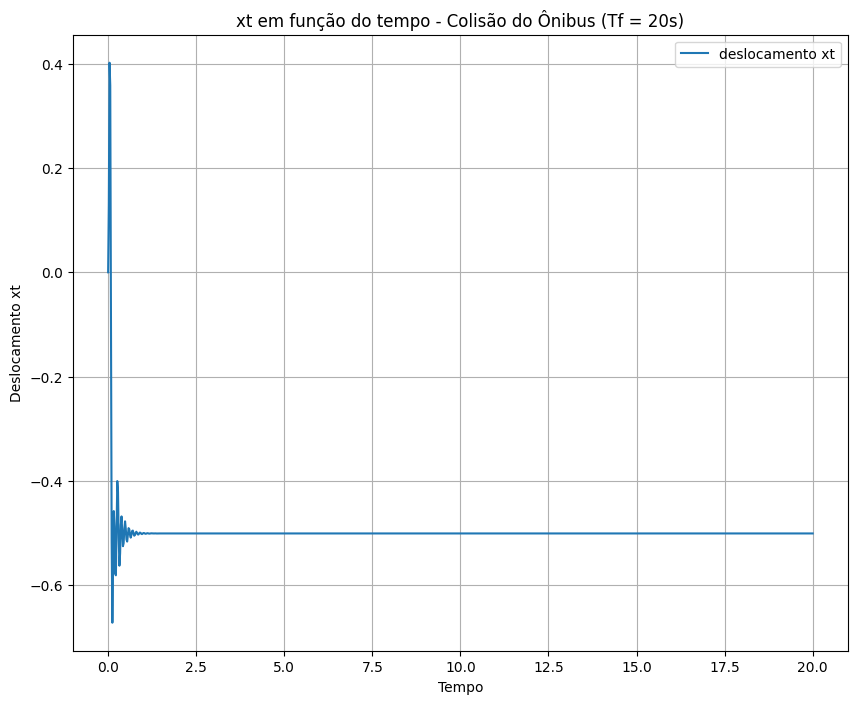

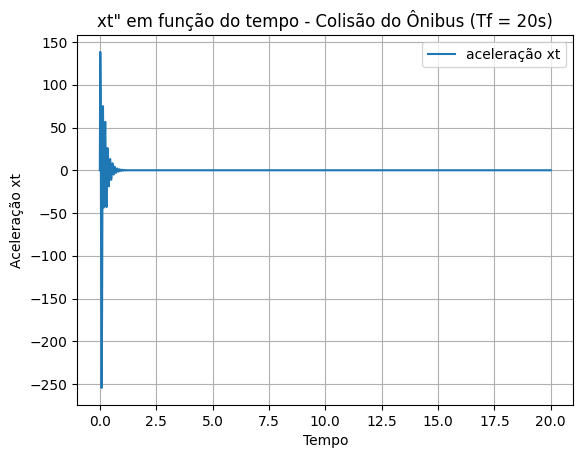

In [231]:
#idem para colisão 20s
#aceleração com 20s


def equations(t, y, mb, mt, mm, mc, jc, Bc, Kc, g, Lc, kb, kt, km, kcinto, kpe, bb, bt, bm, bcinto, bpe, u):
    xb, xt, xm, theta, xb_p, xt_p, xm_p, theta_p = y


    eq1 = xb_p
    eq2 = xt_p
    eq3 = xm_p
    eq4 = theta_p

    eq5 = -((kb+kcinto)/mb)*xb-(kcinto/mb)*xt-((bb+bcinto)/mb)*xb_p-(bcinto/mb)*xt_p - kcinto*u

    eq6 = -(kcinto/(mt+mc))*xb-((kcinto+km)/(mt+mc))*xt+(km/(mt+mc))*xm+(bcinto/(mt+mc))*xb_p-((bcinto+bm)/(mt+mc))*xt_p+(bm/(mt+mc))*xm_p  

    eq7 = (km/mm)*xt-((km+kpe)/mm)*xm+(bm/mm)*xt_p-((bm+bpe)/mm)*xm_p - kpe*u

    eq8 = ((mc*Lc*g-Kc)/(jc+mc*Lc**2))*theta-((Bc)/jc+mc*Lc**2)*theta_p


    return [eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8]

u = -0.425#m

 #velocidade de 36 km/h ou 10m/s (u = 0.305)
#velocidade de 46 km/h ou 12.7m/s (u = 0.425)
# Condições iniciais
initial_conditions = [0, 0, 0, 0, 0, 0, 0, 0]

# Tempo de integração
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solução do sistema de equações diferenciais
sol = solve_ivp(
    fun=lambda t, y: equations(t, y, mb, mt, mm, mc, jc, Bc, Kc, g, Lc, kb, kt, km, kcinto, kpe, bb, bt, bm, bcinto, bpe, u),
    t_span=t_span,
    y0=initial_conditions,
    t_eval=t_eval,
    method='DOP853'
)

# Plotando os resultados
plt.figure(figsize=(10, 8))

plt.plot(sol.t, sol.y[1]/10, label='deslocamento xt')
plt.title('xt em função do tempo - Colisão do Ônibus (Tf = 20s)')
plt.xlabel('Tempo')
plt.ylabel('Deslocamento xt')
plt.legend()
plt.grid(True)
plt.show()
plt.plot(sol.t, sol.y[5], label='aceleração xt')
plt.title('xt" em função do tempo - Colisão do Ônibus (Tf = 20s)')
plt.xlabel('Tempo')
plt.ylabel('Aceleração xt')
plt.legend()
plt.grid(True)
plt.show()



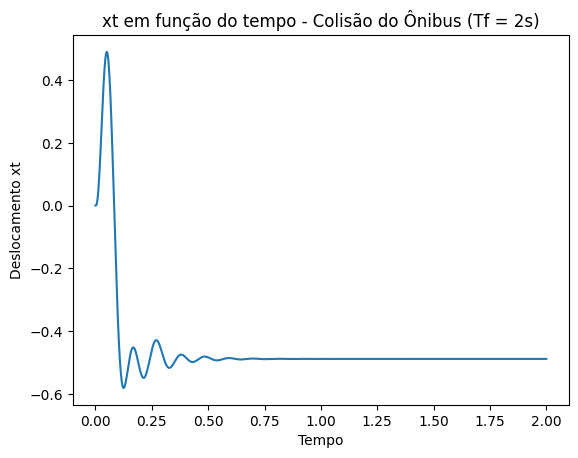

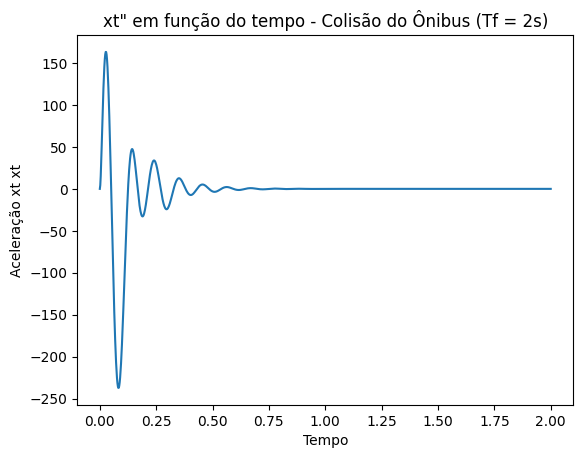

In [232]:
#colisão 2s
#aceleração com 2s
# Condições iniciais
xb0 = 0  # m
xt0 = 0  # m (ajustado para um valor diferente de zero)
xp0 = 0  # m (ajustado para um valor diferente de zero)
teta0 = 0  # rad
xbp0 = 0  # m
xtp0 = 0  # m
xmp0 = 0  # m
tetap0 = 0  # rad
u = -0.425 # m
#velocidade de 36km/h ou 10m/s (u = 0.305)
#velocidade de 46km/h ou 12.7m/s (u = 0.425)
# Condições iniciais do sistema
x0 = [xb0, xt0, xp0, teta0, xbp0, xtp0, xmp0, tetap0]

def sistema_naoLinear(t, x):
    xb, xt, xm, teta, xbp, xtp, xmp, tetap = x

    # Equações do sistema
    eq1 = xbp
    eq2 = xtp
    eq3 = xmp
    eq4 = tetap
    eq5 = -((kb + kt) / mb) * xb - (kt / mb) * xt - ((bb + bt) / mb) * xbp - (bt / mb) * xtp - kcinto*u
    eq6 = -(kt / (mt + mc)) * xb - ((kt + km) / (mt + mc)) * xt + (km / (mt + mc)) * xm + (bt / (mt + mc)) * xbp - (
                (bt + bm) / (mt + mc)) * xtp + (bm / (mt + mc)) * xmp 
    eq7 = (km / mm) * xt - ((km + kpe) / mm) * xm + (bm / mm) * xtp - ((bm + bpe) / mm) * xmp - kpe*u
    eq8 = ((mc * Lc * g - Kc) / (jc + mc * Lc ** 2)) * teta - ((Bc) / (jc + mc * Lc ** 2)) * tetap 

    return [eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8]

tf = 2.0
t = np.linspace(0, tf, 1000)

# Resolvendo as equações
s_n = solve_ivp(sistema_naoLinear, [0, tf], x0, method='DOP853', dense_output=True)
x_n = s_n.sol(t)

xt = x_n[1]
xt_pp = x_n[5]

# Plote o gráfico para a equação 2 (xt)
plt.title('xt em função do tempo - Colisão do Ônibus (Tf = 2s)')
plt.plot(t, xt/10)
plt.xlabel('Tempo')
plt.ylabel('Deslocamento xt')
plt.show()
plt.title('xt" em função do tempo - Colisão do Ônibus (Tf = 2s)')
plt.plot(t, xt_pp)
plt.xlabel('Tempo')
plt.ylabel('Aceleração xt xt')
plt.show()



Plotar gráfico

In [233]:
plt.figure(figsize=(10, 6))
plt.plot(t, velbanco, label='Velocidade do Banco')
plt.xlabel('Tempo')
plt.ylabel('Velocidade do Banco')
plt.title('Gráfico de velocidade do banco no tronco em função do tempo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, veltronco, label='Velocidade do Tronco')
plt.xlabel('Tempo')
plt.ylabel('Velocidade do Tronco')
plt.title('Gráfico da velocidade do tronco em função do tempo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, velpernas, label='velocidade das pernas')
plt.xlabel('Tempo')
plt.ylabel('Velocidade das Pernas')
plt.title('Gráfico da velocidade das pernas em função do tempo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, velangcabeca, label='Velocidade angular da Cabeça + Pescoço')
plt.xlabel('Tempo')
plt.ylabel('Velocidade angular da Cabeça + Pescoço')
plt.title('Gráfico da velocidade angular da cabeça + pescoço em função do tempo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, acbanco, label='Aceleração do Banco')
plt.xlabel('Tempo')
plt.ylabel('Aceleração do Banco')
plt.title('Gráfico da aceleração do banco em função do tempo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, actronco, label='Aceleração do Tronco')
plt.xlabel('Tempo')
plt.ylabel('Aceleração do Tronco')
plt.title('Gráfico da aceleração do tronco em função do tempo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, acpernas, label='Aceleração das Pernas')
plt.xlabel('Tempo')
plt.ylabel('Aceleração das Pernas')
plt.title('Gráfico de aceleração das pernas em função do tempo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, acangcabeca, label='Aceleração Angular da Cabeça')
plt.xlabel('Tempo')
plt.ylabel('Aceleração Angular da Cabeça')
plt.title('Gráfico da aceleração angular da cabeça em função do tempo')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'velbanco' is not defined

<Figure size 1000x600 with 0 Axes>